In [ ]:
!pip install eefolium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Importing required packages
# ee is the official package built by Google to access Google Earth Engine
# geemap is a package for interactive mapping with Google Earth Engine
import ee
import eefolium as geemap

In [ ]:
# Authenticating with Google Earth Engine
# WARNING: when you input the verification code, press Enter
# Do not run cell or you could need to restart Jupyter to continue working
ee.Authenticate()

In [ ]:
# Connecting to Google Earth Engine
ee.Initialize(project='ee-eced692')

In [ ]:
# ee.FeatureCollection can contain geometrical objects.
# In this case, we have used it to contain the limits of Sierra Nevada protected area.
# You have to CHANGE THE PATH TO YOUR HOME FOLDER within GEE
zone = ee.FeatureCollection('projects/ee-eced692/assets/pnatural_23030')

In [ ]:
def get_NDVI(img):
  return img.addBands(img.normalizedDifference(["B4", "B3"]).rename("NDVI"))

In [ ]:
l7collection = (
    ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
    .filterBounds(zone)
    .filterDate("1999-01-01", "1999-12-31")
)

l7ndvi = l7collection.map(get_NDVI)

composite = l7ndvi.qualityMosaic("NDVI").clip(zone)

band = composite.select("NDVI")

...
qualityMosaic coge el valor máximo de un pixel a lo largo de una serie temporal.
de la colección l7ndvi, nos coge la banda "NDVI" y clip es que recorta el mapa al parque natural (zone)

In [ ]:
m = geemap.Map()

m.centerObject(zone, zoom=10)

vis_params = {"min": 0, "max": 1, "palette": ['#e5f5e0','#a1d99b','#31a354']}

m.addLayer(band, vis_params, "NDVI")

m

Ahora vamos a hacer esto mismo pero para varios años, para ello usaremos los BUCLES.

In [ ]:
bands = []

years = range(2011, 2021)
for year in years:
  str_year = str(year)
  print(str_year)
  l7collection = (
    ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
    .filterBounds(zone)
    .filterDate(str_year + "-01-01", str_year + "-12-31")
  )

  l7ndvi = l7collection.map(get_NDVI)

  composite = l7ndvi.qualityMosaic("NDVI").clip(zone)

  band = composite.select("NDVI")

  bands.append(band)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [ ]:
m = geemap.Map()

m.centerObject(zone, zoom=10)

vis_params = {"min": 0, "max": 1, "palette": ['#e5f5e0','#a1d99b','#31a354']}

for posicion, banda in enumerate(bands):
  m.addLayer(banda, vis_params, "NDVI_" + str(2011 + posicion))

m.addLayerControl()

m

**NDVI value in a specific point (lat, long)**

In [ ]:
lat = 37.0311
lon = -3.3259
point = ee.Geometry.Point((lon, lat))

In [ ]:
data_point = []
for band in bands:
  data_point.append(band.reduceRegion(ee.Reducer.max(), point, 30).get("NDVI").getInfo())
data_point

[0.2708846926689148,
 0.35672202706336975,
 0.29898107051849365,
 0.3055393695831299,
 0.31735706329345703,
 0.40142637491226196,
 0.35356849431991577,
 0.3559139668941498,
 0.3727618157863617,
 0.40182793140411377]

Montamos drive, que colab tenga acceso a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Axes: xlabel='Year'>

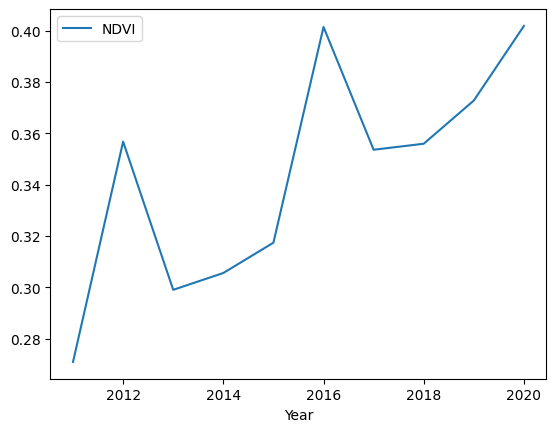

In [ ]:
import pandas as pd

df = pd.DataFrame({"NDVI":data_point}, index=range(2011, 2021))
df.index = df.index.rename("Year")

#Creamos un .csv
df.to_csv('/content/drive/My Drive/Ecoinformatica/ndvi.csv')

df.plot()

**Mean value en Sierra Nevada**

In [ ]:
data_sn = []
for band in bands:
    data_sn.append(band.reduceRegion(ee.Reducer.mean(), zone, 30).get("NDVI").getInfo())
data_sn

[0.4389441632511864,
 0.43759124554545414,
 0.46258991901619434,
 0.43935823237463706,
 0.442469510819633,
 0.4295157183756784,
 0.4432493587405777,
 0.4674906498242192,
 0.462930568881703,
 0.4681666809172805]

<Axes: xlabel='Year'>

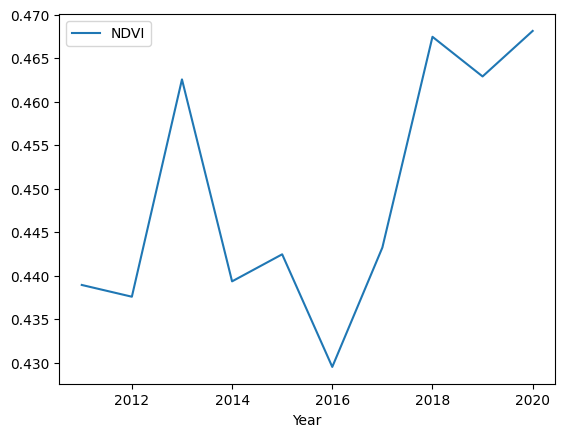

In [ ]:
df = pd.DataFrame({"NDVI":data_sn}, index=range(2011, 2021))
df.index = df.index.rename("Year")

df.plot()

**Now we want to export the NDVI time series rasters to our Google Drive folder**

In [ ]:
for i, band in enumerate(bands):
  geemap.ee_export_image_to_drive(
      band, "ndvi_"+str(2011+i), folder="GEE_ECOINF", region=zone.geometry(), scale=30
  )

Exporting ndvi_2011 ...
Exporting ndvi_2012 ...
Exporting ndvi_2013 ...
Exporting ndvi_2014 ...
Exporting ndvi_2015 ...
Exporting ndvi_2016 ...
Exporting ndvi_2017 ...
Exporting ndvi_2018 ...
Exporting ndvi_2019 ...
Exporting ndvi_2020 ...


**We will use the Mann-Kendall trend test to detect a trend in a series of values. Mann-Kendall trend test is a nonparametric test.**

In [ ]:
# Generate a single file with the different layers (bands)
stack_collection = ee.ImageCollection(bands)
ndvis = stack_collection.toBands()

In [ ]:
ndvi_trend = ndvis.reduce(ee.Reducer.kendallsCorrelation())
tau = ndvi_trend.select("tau") # Negative values indicate a decreasing trend and positive values indicate an increasing trend

In [ ]:
m = geemap.Map()

m.centerObject(zone, zoom = 10)

vis_params = {"min": -1, "max": 1, "palette": ["red", "orange", "white", "green"]}

m.addLayer(tau, vis_params, "Mann-Kendal")

m

In [ ]:
geemap.ee_export_image_to_drive(
        tau, "tau", folder="GEE_ECOINF", region=zone.geometry(), scale=30
    )